In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import uproot
import awkward as ak
%matplotlib inline


#data_path = "/dipc/elena/WCTE_2025_commissioning/root_files/data/260MeVc/WCTE_offline_R1574S0_VME1558.root"  #260MeV/c  44 pion-only events

data_path = "/dipc/elena/WCTE_2025_commissioning/root_files/data/WCTE_offline_R1711S0_VME1650.root"   #260MeV/c, 52 pion-only events
mc_path = "/dipc/elena/WCTE_2025_commissioning/root_files/mc/pi+_260MeVc_1000evts_masked.root"
tree ="WCTEReadoutWindows"
n_events = 3000

data_tree = uproot.open(f"{data_path}:{tree}")
mc_tree = uproot.open(f"{mc_path}:{tree}")


data = data_tree.arrays(entry_stop = n_events, library="ak")
mc = mc_tree.arrays(entry_stop = n_events, library="ak")

In [2]:
print(f"Data events loaded: {len(data['event_number'])}")  
print(f"MC events loaded: {len(mc['event_number'])}")

Data events loaded: 3000
MC events loaded: 3000


In [3]:
for branch in (data.fields):
    print(branch, ak.type(data[branch]))  #if "var", variable number of elements

window_time 3000 * float64
run_id 3000 * int32
sub_run_id 3000 * int32
spill_counter 3000 * int32
event_number 3000 * int32
readout_number 3000 * int32
trigger_types 3000 * var * int32
trigger_times 3000 * var * float64
led_gains 3000 * var * float32
led_dacsettings 3000 * var * float32
led_ids 3000 * var * int32
led_card_ids 3000 * var * int32
led_slot_numbers 3000 * var * int32
led_event_types 3000 * var * int32
led_types 3000 * var * int32
led_sequence_numbers 3000 * var * int32
led_counters 3000 * var * int32
hit_mpmt_card_ids 3000 * var * int32
hit_pmt_channel_ids 3000 * var * int32
hit_mpmt_slot_ids 3000 * var * int32
hit_pmt_position_ids 3000 * var * int32
hit_pmt_charges 3000 * var * float32
hit_pmt_times 3000 * var * float64
pmt_waveform_mpmt_card_ids 3000 * var * int32
pmt_waveform_pmt_channel_ids 3000 * var * int32
pmt_waveform_mpmt_slot_ids 3000 * var * int32
pmt_waveform_pmt_position_ids 3000 * var * int32
pmt_waveform_times 3000 * var * float64
pmt_waveforms 3000 * var * 

In [4]:
import sys
sys.path.append("/scratch/elena/WCTE_2025_commissioning/2025_data")
import DataQualityNotebooks.VMEAnalysis as VMEAnalysisModule
import importlib
importlib.reload(VMEAnalysisModule) 
from DataQualityNotebooks.VMEAnalysis import VMEAnalysis


config_file = "/scratch/elena/WCTE_2025_commissioning/config/lep_v51_config.json"
vme_analysis_cut = {
    "t4_qcut": 300,
    "hc0_cut": 150,
    "hc1_cut": 100,
    "act1_ev": 900,
    "act2_pi": 1800,
    "act2_mu_low": 2000,
    "act2_mu_high": 10000,
    "tdc_cut": 200
}

#extract the interesting variables
qdc_charges = data["beamline_pmt_qdc_charges"]
qdc_ids = data["beamline_pmt_qdc_ids"]
tdc_times = data["beamline_pmt_tdc_times"]
tdc_ids = data["beamline_pmt_tdc_ids"]

#initialize the VMEAnalysis object
vme = VMEAnalysis(config_file, vme_analysis_cut, runNumber=1574)

#load data into the analysis object
q, tdc = vme.load_data(qdc_ids, qdc_charges, tdc_ids, tdc_times)

#apply cuts (mask)
vme.make_cuts_on_data(qdc_ids, qdc_charges, tdc_ids, tdc_times)

#mask for pion-only
pion_mask = vme.getEventMask("pion-only")

#apply mask to the awkward array to filter events
data = data[pion_mask]

print(f"Selected {len(data)} pion-like events")     #out of {len(df_data)} total events")

Current Working Directory: /scratch/elena/WCTE_2025_commissioning
[INFO] Total events: 3000
[INFO] Computing activity sums and TOF values...
[INFO] Applying additional cuts...
[INFO] Defining cut sequences...
[INFO] Converting to NumPy for stats...
[INFO] Gathering statistics per cut set...
Selected 52 pion-like events


# let's explore the waverforms of Data

In [5]:
for branch in (data.fields):
    if "waveform" in branch.lower():
        print(branch, ak.type(data[branch]))  #if "var", variable number of elements

pmt_waveform_mpmt_card_ids 52 * var * int32
pmt_waveform_pmt_channel_ids 52 * var * int32
pmt_waveform_mpmt_slot_ids 52 * var * int32
pmt_waveform_pmt_position_ids 52 * var * int32
pmt_waveform_times 52 * var * float64
pmt_waveforms 52 * var * var * float64


In [6]:
data_wave = ak.flatten(data["pmt_waveforms"])
print(data_wave)

[[0, -1, -1, 0, -1, 0, 2, 23, 61, 56, 7, ... -3, -3, -1, -2, -2, -2, -2, -3, -3, -3]]


In [7]:
print(data["pmt_waveform_mpmt_card_ids"][0])  # card ids for event 0
print(data["pmt_waveform_pmt_channel_ids"][0])
print(data["pmt_waveform_mpmt_slot_ids"][0])
print(data["pmt_waveform_pmt_position_ids"][0])
print(data["pmt_waveform_times"][0])
print(data["pmt_waveforms"][0])

[25, 132, 132, 132, 132, 132, 26, 17, 17, ... 130, 130, 130, 130, 130, 130, 130, 130]
[0, 17, 18, 1, 10, 19, 18, 2, 4, 7, 8, ... 1, 13, 15, 14, 16, 7, 19, 14, 15, 13, 16]
[62, -1, -1, -1, -1, -1, 60, 29, 29, 29, ... -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[17, -2, -2, -2, -2, -2, 16, 0, 1, 2, 9, ... -2, -2, -2, -2, -2, -2, -2, -2, -2, -2]
[2.27e+03, 2.17e+03, 2.17e+03, 2.19e+03, ... 2.42e+03, 2.42e+03, 2.44e+03, 2.44e+03]
[[0, -1, -1, 0, -1, 0, 2, 23, 61, 56, ... 18, 17, -33, -51, -39, -44, -53, -50, -45]]


In [8]:
event_index = 0

card_ids = data["pmt_waveform_mpmt_card_ids"][event_index]
slot_ids = data["pmt_waveform_mpmt_slot_ids"][event_index]
channel_ids = data["pmt_waveform_pmt_channel_ids"][event_index]
position_ids = data["pmt_waveform_pmt_position_ids"][event_index]
times = data["pmt_waveform_times"][event_index]
waveforms = data["pmt_waveforms"][event_index]

# Create a mask of which waveforms to keep
mask = [(c < 120) and (s != -1) for c, s in zip(card_ids, slot_ids)]

# Apply mask to filter all arrays
filtered_card_ids = [c for c, keep in zip(card_ids, mask) if keep]
filtered_slot_ids = [s for s, keep in zip(slot_ids, mask) if keep]
filtered_channel_ids = [ch for ch, keep in zip(channel_ids, mask) if keep]
filtered_position_ids = [p for p, keep in zip(position_ids, mask) if keep]
filtered_times = [t for t, keep in zip(times, mask) if keep]
filtered_waveforms = [wf for wf, keep in zip(waveforms, mask) if keep]

print("Original number of waveforms:", len(card_ids))
print("Filtered number of waveforms:", len(filtered_card_ids))

Original number of waveforms: 228
Filtered number of waveforms: 205


In [9]:
original_waves = []
filtered_waves = []

# Containers to store filtered data if you want to keep it
filtered_data = {
    "card_ids": [],
    "slot_ids": [],
    "channel_ids": [],
    "position_ids": [],
    "times": [],
    "waveforms": []
}

for event_index in range(len(data)):
    card_ids = data["pmt_waveform_mpmt_card_ids"][event_index]
    slot_ids = data["pmt_waveform_mpmt_slot_ids"][event_index]
    channel_ids = data["pmt_waveform_pmt_channel_ids"][event_index]
    position_ids = data["pmt_waveform_pmt_position_ids"][event_index]
    times = data["pmt_waveform_times"][event_index]
    waveforms = data["pmt_waveforms"][event_index]
    
    original_waves.append(len(card_ids))
    

    mask = [(c < 120) and (s != -1) for c, s in zip(card_ids, slot_ids)]
    

    filtered_waves.append(sum(mask))
    
 
    filtered_data["card_ids"].append([c for c, keep in zip(card_ids, mask) if keep])
    filtered_data["slot_ids"].append([s for s, keep in zip(slot_ids, mask) if keep])
    filtered_data["channel_ids"].append([ch for ch, keep in zip(channel_ids, mask) if keep])
    filtered_data["position_ids"].append([p for p, keep in zip(position_ids, mask) if keep])
    filtered_data["times"].append([t for t, keep in zip(times, mask) if keep])
    filtered_data["waveforms"].append([wf for wf, keep in zip(waveforms, mask) if keep])


#df to display the filtering 
df_waves = pd.DataFrame({
    "original_waveforms": original_waves,
    "filtered_waveforms": filtered_waves
})

print(df_waves)

    original_waveforms  filtered_waveforms
0                  228                 205
1                  125                  97
2                  202                 174
3                  757                 711
4                  238                 221
5                 1009                 952
6                  104                  80
7                  363                 338
8                  268                 245
9                  311                 269
10                 365                 335
11                 158                 134
12                 943                 905
13                 422                 392
14                  71                  42
15                 332                 308
16                 183                 155
17                 728                 701
18                 484                 461
19                1381                1317
20                1302                1277
21                 462                 438
22         

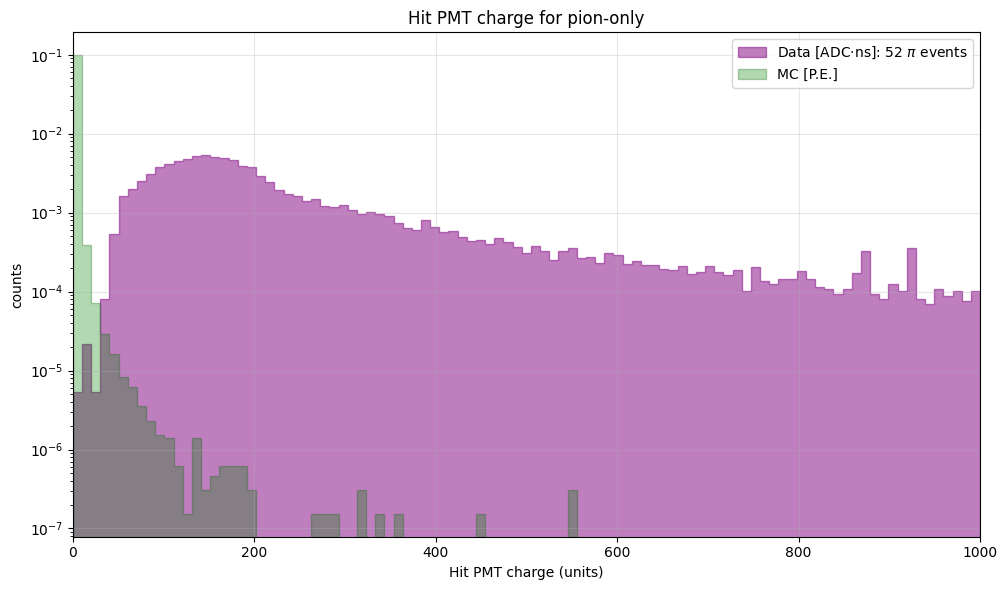

In [10]:
data_charges = ak.flatten(data["hit_pmt_charges"])
mc_charges   = ak.flatten(mc["hit_pmt_charges"])

min_range_charge = 0
max_range_charge = 1000

data_charges = data_charges[(data_charges >= min_range_charge) & (data_charges <= max_range_charge)]
mc_charges   = mc_charges[(mc_charges >= min_range_charge) & (mc_charges <= max_range_charge)]

bins = np.linspace(min_range_charge, max_range_charge, 100)

plt.figure(figsize=(10, 6))

# --- Histograms with edgecolor ---
plt.hist(data_charges, bins=bins, alpha=0.5, color='purple',
         label=f'Data [ADC·ns]: {len(data)} $\pi$ events',
         histtype='stepfilled', density=True, edgecolor='purple')
plt.hist(mc_charges, bins=bins, alpha=0.3, color='green',
         label='MC [P.E.]',
         histtype='stepfilled', density=True, edgecolor='darkgreen')

plt.yscale('log')
plt.xlabel('Hit PMT charge (units)')
plt.ylabel('counts')
plt.title('Hit PMT charge for pion-only')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.xlim(min_range_charge, max_range_charge)
plt.show()

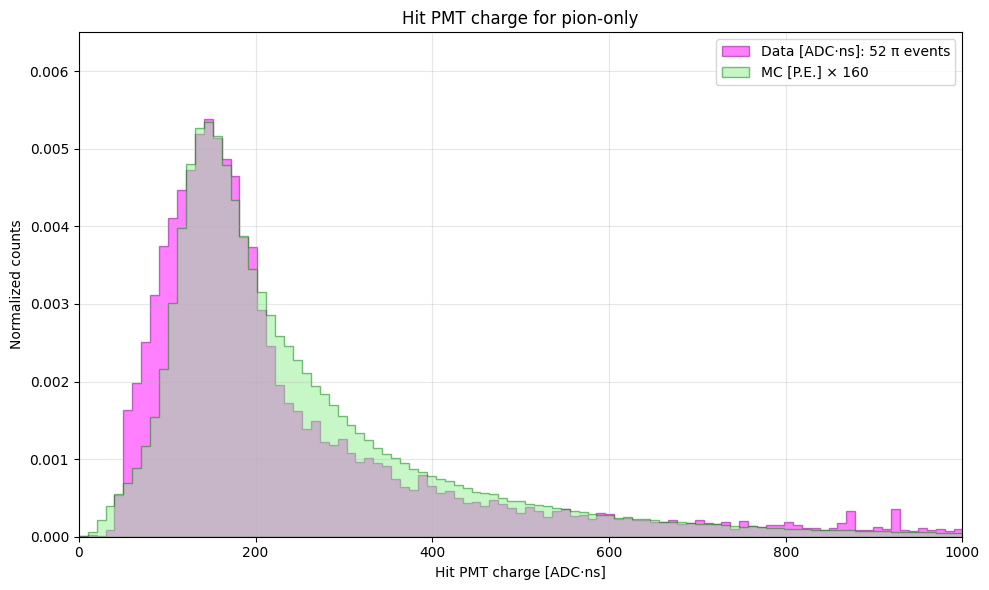

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak

# -------------------------------
# Flatten charges
# -------------------------------
data_charges = ak.to_numpy(ak.flatten(data["hit_pmt_charges"]))
mc_charges   = ak.to_numpy(ak.flatten(mc["hit_pmt_charges"])) * 160  # scale factor

# -------------------------------
# Apply charge cuts
# -------------------------------
min_range_charge = 0
max_range_charge = 1000

data_charges = data_charges[(data_charges >= min_range_charge) & (data_charges <= max_range_charge)]
mc_charges   = mc_charges[(mc_charges >= min_range_charge) & (mc_charges <= max_range_charge)]

# -------------------------------
# Histogram bins
# -------------------------------
bins = np.linspace(min_range_charge, max_range_charge, 100)

# -------------------------------
# Plot
# -------------------------------
plt.figure(figsize=(10, 6))

# Data histogram
plt.hist(data_charges, bins=bins, alpha=0.5, color='magenta',
         label=f'Data [ADC·ns]: {len(data)} π events',
         histtype='stepfilled', density=True, edgecolor='purple')

# MC histogram
plt.hist(mc_charges, bins=bins, alpha=0.5, color='lightgreen',
         label='MC [P.E.] × 160',
         histtype='stepfilled', density=True, edgecolor='green')

# -------------------------------
# Axes and labels
# -------------------------------
plt.xlabel('Hit PMT charge [ADC·ns]')
plt.ylabel('Normalized counts')
plt.title('Hit PMT charge for pion-only')
plt.legend()
plt.grid(True, alpha=0.3)

# Set exact x and y limits
plt.xlim(min_range_charge, max_range_charge)
plt.ylim(0, 0.0065)

# Force y ticks to show only up to 0.006
plt.yticks(np.linspace(0, 0.006, 7))  # 0.0, 0.001, ..., 0.006

plt.tight_layout()
plt.show()

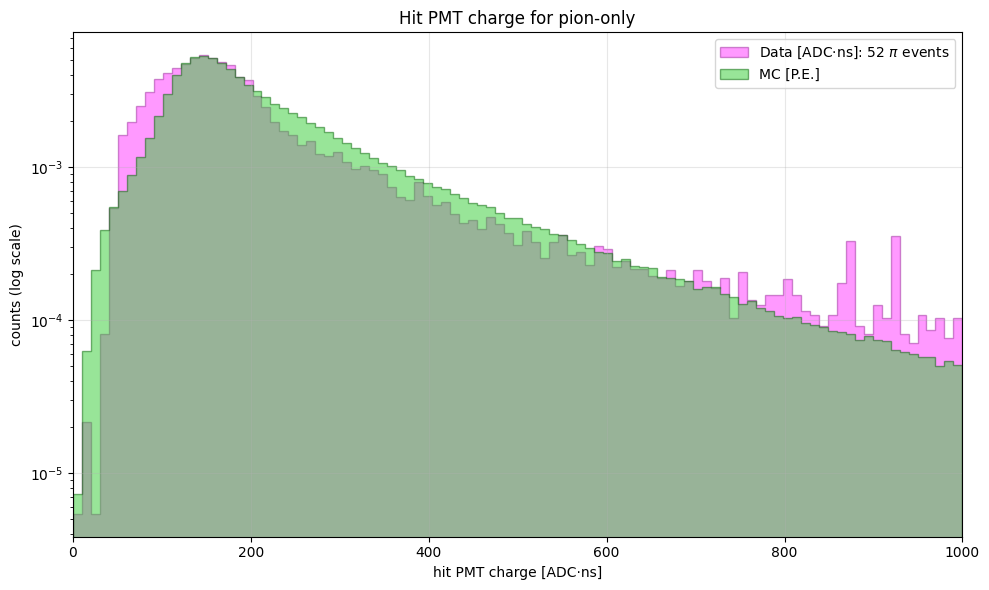

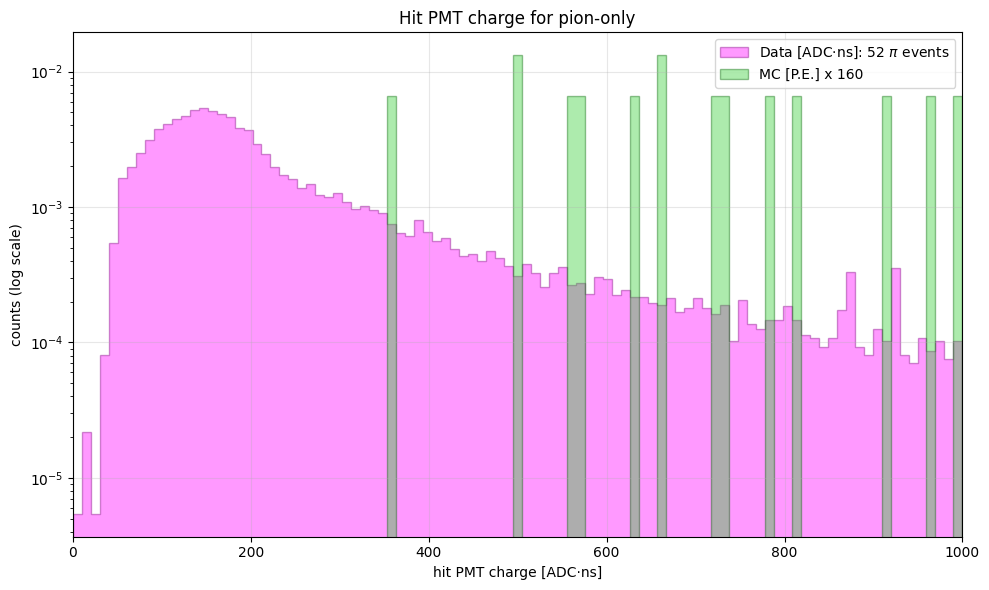

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak

# --- Usamos los mismos data_charges y mc_charges filtrados pion-only ---
# data_charges ya filtrado
# mc_charges raw ya filtrado
mc_charges_scaled = mc_charges * 160  # scale factor

min_range_charge = 0
max_range_charge = 1000
bins = np.linspace(min_range_charge, max_range_charge, 100)

# --- Plot 1: MC no escalado ---
plt.figure(figsize=(10, 6))
plt.hist(data_charges, bins=bins, alpha=0.4, color='magenta',
         label=f'Data [ADC·ns]: {len(data)} $\pi$ events',
         histtype='stepfilled', density=True, edgecolor='purple')
plt.hist(mc_charges, bins=bins, alpha=0.5, color='limegreen',
         label='MC [P.E.]',
         histtype='stepfilled', density=True, edgecolor='darkgreen')
plt.yscale('log')
plt.xlabel('hit PMT charge [ADC·ns]')
plt.ylabel('counts (log scale)')
plt.title('Hit PMT charge for pion-only')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(min_range_charge, max_range_charge)
plt.tight_layout()
plt.show()

# --- Plot 2: MC escalado x160 ---
plt.figure(figsize=(10, 6))
plt.hist(data_charges, bins=bins, alpha=0.4, color='magenta',
         label=f'Data [ADC·ns]: {len(data)} $\pi$ events',
         histtype='stepfilled', density=True, edgecolor='purple')
plt.hist(mc_charges_scaled, bins=bins, alpha=0.4, color='limegreen',
         label='MC [P.E.] x 160',
         histtype='stepfilled', density=True, edgecolor='darkgreen')
plt.yscale('log')
plt.xlabel('hit PMT charge [ADC·ns]')
plt.ylabel('counts (log scale)')
plt.title('Hit PMT charge for pion-only')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(min_range_charge, max_range_charge)
plt.tight_layout()
plt.show()

In [13]:
print(mc.fields)


['event_number', 'window_time', 'run_id', 'sub_run_id', 'spill_counter', 'readout_number', 'hit_mpmt_card_ids', 'hit_pmt_channel_ids', 'hit_mpmt_slot_ids', 'hit_pmt_position_ids', 'hit_pmt_charges', 'hit_pmt_times', 'trigger_types', 'trigger_times', 'led_gains', 'led_dacsettings', 'led_ids', 'led_card_ids', 'led_slot_numbers', 'led_event_types', 'led_types', 'led_sequence_numbers', 'led_counters', 'beamline_pmt_qdc_charges', 'beamline_pmt_qdc_ids', 'beamline_pmt_tdc_times', 'beamline_pmt_tdc_ids']


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import sys

gain_file = "/scratch/elena/WCTE_2025_commissioning/2025_data/WCTE_BRB_Data_Analysis/pmt_charge_fit_results_doubleGauss.npz"
data_array = np.load(gain_file)["results"]


wcte_event_display_path = "/scratch/elena/WCTE_2025_commissioning/2025_data/WCTE_event_display"
sys.path.append(wcte_event_display_path)
from EventDisplay import EventDisplay

#mapping with EventDisplay
ed = EventDisplay()
ed.load_mPMT_positions("mPMT_2D_projection_angles.csv")


gain_per_channel = np.full(ed.nChannels, np.nan)
for i in range(len(data_array)):
    slot  = data_array['slot_id'][i]
    ch    = data_array['channel_id'][i]
    gain  = data_array['gain'][i]
    idx = 19 * slot + ch
    if idx < ed.nChannels:
        gain_per_channel[idx] = gain


mc_charges = ak.flatten(mc["hit_pmt_charges"])
mc_slot_ids = ak.flatten(mc["hit_mpmt_slot_ids"])
mc_channel_ids = ak.flatten(mc["hit_pmt_channel_ids"])


mask = mc_slot_ids != -1
mc_charges     = mc_charges[mask]
mc_slot_ids    = mc_slot_ids[mask]
mc_channel_ids = mc_channel_ids[mask]


mc_charges     = ak.to_numpy(mc_charges)
mc_slot_ids    = ak.to_numpy(mc_slot_ids)
mc_channel_ids = ak.to_numpy(mc_channel_ids)


data_charges = ak.to_numpy(ak.flatten(data["hit_pmt_charges"]))
data_slot_ids = ak.to_numpy(ak.flatten(data["hit_mpmt_slot_ids"]))
data_channel_ids = ak.to_numpy(ak.flatten(data["hit_pmt_channel_ids"]))

# ADC·ns → P.E.
data_idx = 19 * data_slot_ids + data_channel_ids
data_charges_pe = data_charges / gain_per_channel[data_idx]


min_range_charge = 0
max_range_charge = 10

data_charges_pe = data_charges_pe[(data_charges_pe >= min_range_charge) & (data_charges_pe <= max_range_charge)]
mc_charges = mc_charges[(mc_charges >= min_range_charge) & (mc_charges <= max_range_charge)]

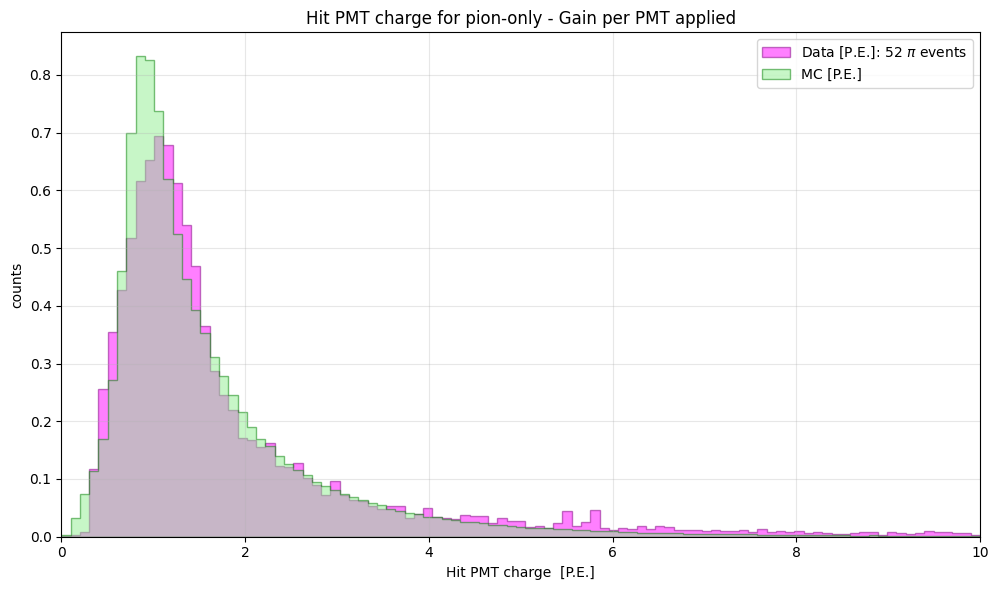

In [15]:
bins = np.linspace(min_range_charge, max_range_charge, 100)

plt.figure(figsize=(10, 6))
plt.hist(data_charges_pe, bins=bins, alpha=0.5, color='magenta', label=f'Data [P.E.]: {len(data)} $\pi$ events', 
         histtype='stepfilled', density=True, edgecolor='purple')
plt.hist(mc_charges, bins=bins, alpha=0.5, color='lightgreen', label='MC [P.E.]',
         histtype='stepfilled', density = True, edgecolor='green')

#plt.yscale("log")
plt.xlabel('Hit PMT charge  [P.E.]')
plt.ylabel('counts')
plt.title('Hit PMT charge for pion-only - Gain per PMT applied')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.xlim(min_range_charge, max_range_charge)
plt.show()

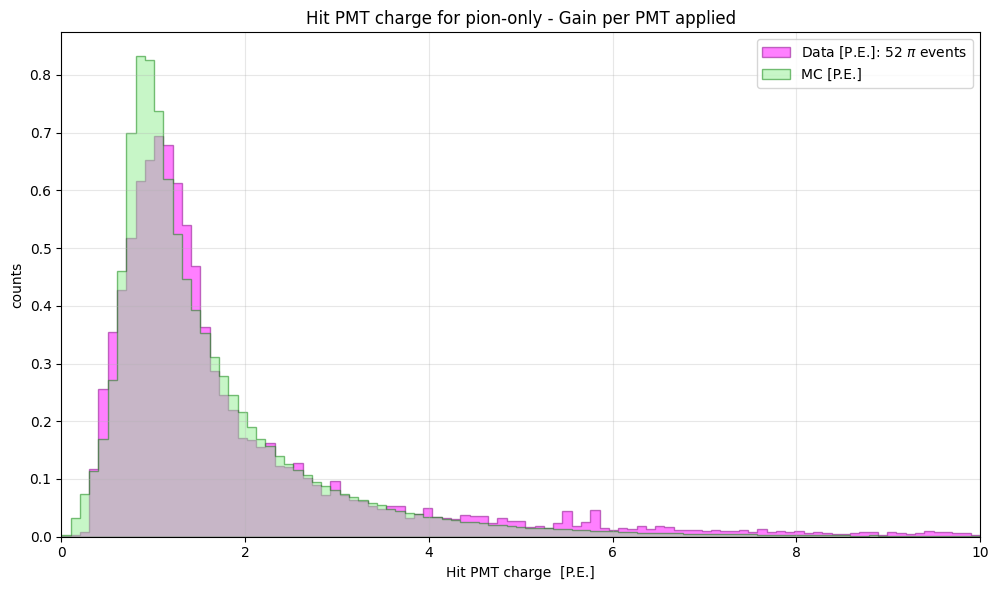

In [16]:
mc_weights = np.ones_like(mc_charges)*(len(data_charges_pe) / len(mc_charges))

bins = np.linspace(min_range_charge, 10, 100)

plt.figure(figsize=(10, 6))
plt.hist(data_charges_pe, bins=bins, alpha=0.5, color='magenta', label=f'Data [P.E.]: {len(data)} $\pi$ events', 
         histtype='stepfilled', density=True, edgecolor='purple')
plt.hist(mc_charges, bins=bins, alpha=0.5, color='lightgreen', label='MC [P.E.]',  weights=mc_weights,
         histtype='stepfilled', density = True, edgecolor='green')

#plt.yscale("log")
plt.xlabel('Hit PMT charge  [P.E.]')
plt.ylabel('counts')
plt.title('Hit PMT charge for pion-only - Gain per PMT applied')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.xlim(min_range_charge, 10)
plt.show()

/dipc/elena/.local/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


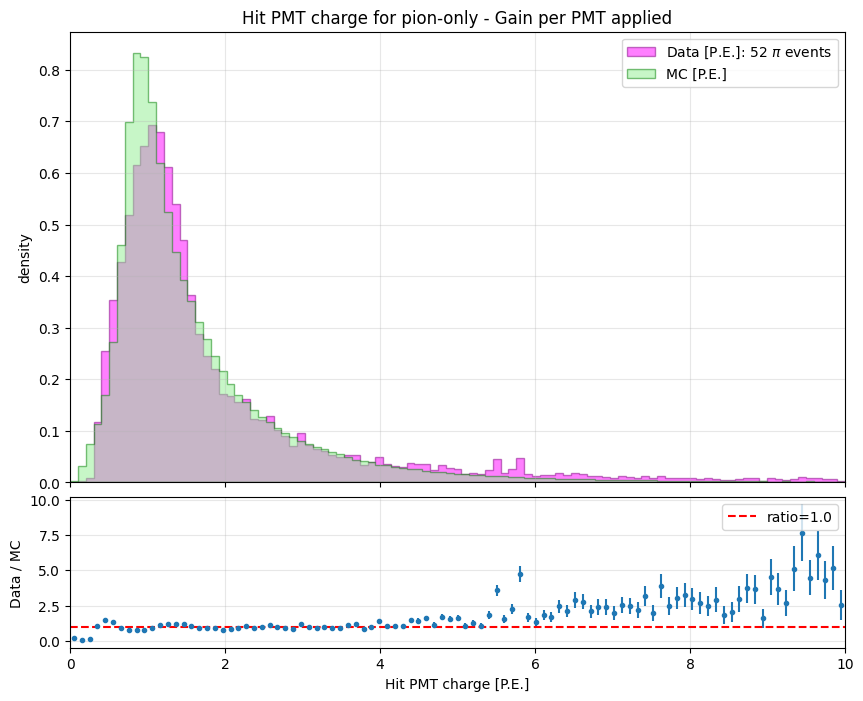

In [17]:
lo = min(np.min(data_charges_pe), np.min(mc_charges), min_range_charge)
hi = 10
bins = np.linspace(lo, hi, 100)

# 2) Histogram **counts** (not density) so statistics are meaningful
data_counts, _ = np.histogram(data_charges_pe, bins=bins)
mc_counts, _   = np.histogram(mc_charges, bins=bins, weights=mc_weights)

# For weighted MC, variance is sum of w^2 per bin
mc_w2, _       = np.histogram(mc_charges, bins=bins, weights=mc_weights**2)

#only take ratio where both sides have entries
valid = (mc_counts > 0) & (data_counts > 0)


ratio = np.full_like(mc_counts, np.nan, dtype=float)
ratio[valid] = data_counts[valid] / mc_counts[valid]

data_err = np.sqrt(data_counts.astype(float))
mc_err   = np.sqrt(mc_w2)
ratio_err = np.full_like(ratio, np.nan, dtype=float)
ratio_err[valid] = ratio[valid] * np.sqrt((data_err[valid]/data_counts[valid])**2 + (mc_err[valid]/mc_counts[valid])**2)


bin_centers = 0.5*(bins[:-1] + bins[1:])
plt.figure(figsize=(10,8))
gs = plt.GridSpec(2,1, height_ratios=[3,1], hspace=0.05)

ax = plt.subplot(gs[0])
ax.hist(data_charges_pe, bins=bins, alpha=0.5, color='magenta', label=f'Data [P.E.]: {len(data)} $\\pi$ events', 
        histtype='stepfilled', density=True, edgecolor='purple')
ax.hist(mc_charges, bins=bins, alpha=0.5, color='lightgreen', label='MC [P.E.]', weights=mc_weights,
        histtype='stepfilled', density=True, edgecolor='green')
ax.set_ylabel('density')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(lo, hi)
ax.set_title('Hit PMT charge for pion-only - Gain per PMT applied')

#ratio plot
axr = plt.subplot(gs[1], sharex=ax)
axr.errorbar(bin_centers[valid], ratio[valid], yerr=ratio_err[valid], fmt='o', ms=3)
axr.axhline(1.0, color='red', linestyle='--', label="ratio=1.0")
axr.legend()
axr.set_xlabel('Hit PMT charge [P.E.]')
axr.set_ylabel('Data / MC')
axr.grid(True, alpha=0.3)
plt.setp(ax.get_xticklabels(), visible=False)  # hide top x labels
plt.tight_layout()
plt.show()



In [18]:
type(data)

awkward.highlevel.Array

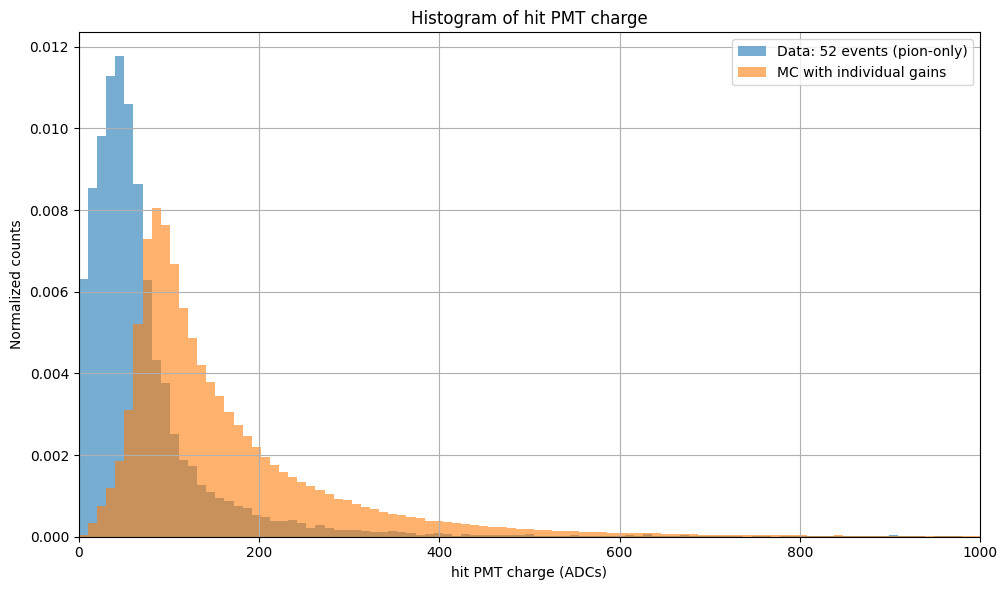

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak

# --- 1. Cargar gains individuales ---
npz_file = "/scratch/elena/WCTE_2025_commissioning/2025_data/WCTE_BRB_Data_Analysis/pmt_charge_fit_results_enhanced.npz"
gain_data = np.load(npz_file)
results = gain_data["results"]

gain_dict = {(c, s, ch): g for c, s, ch, g in zip(
    results['card_id'], results['slot_id'], results['channel_id'], results['gain']
)}

# --- 2. Preparar Data charges pion-only ---
data_charges_list = []

for event_index in range(len(data)):
    card_ids = data["pmt_waveform_mpmt_card_ids"][event_index]
    slot_ids = data["pmt_waveform_mpmt_slot_ids"][event_index]
    channel_ids = data["pmt_waveform_pmt_channel_ids"][event_index]
    waveforms = data["pmt_waveforms"][event_index]

    # Aplica filtros que ya tenías
    mask = [(c < 120) and (s != -1) for c, s in zip(card_ids, slot_ids)]

    # Suma o integra cada waveform (o toma el valor que represente la carga)
    charges = [np.sum(wf) for wf, keep in zip(waveforms, mask) if keep]
    data_charges_list.extend(charges)

data_charges = np.array(data_charges_list)

# --- 3. Preparar MC charges con gains individuales ---
mc_charges_list = []
for event_index in range(len(mc)):
    mc_card_ids     = mc["hit_mpmt_card_ids"][event_index]
    mc_slot_ids     = mc["hit_mpmt_slot_ids"][event_index]
    mc_channel_ids  = mc["hit_pmt_channel_ids"][event_index]
    mc_charges_raw  = mc["hit_pmt_charges"][event_index]

    for charge, c, s, ch in zip(mc_charges_raw, mc_card_ids, mc_slot_ids, mc_channel_ids):
        mc_charges_list.append(charge * gain_dict.get((c, s, ch), 160))

mc_charges = np.array(mc_charges_list)

# --- 4. Filtrar rango ---
min_range_charge = 0
max_range_charge = 1000
data_charges = data_charges[(data_charges >= min_range_charge) & (data_charges <= max_range_charge)]
mc_charges   = mc_charges[(mc_charges >= min_range_charge) & (mc_charges <= max_range_charge)]

# --- 5. Histograma comparativo ---
bins = np.linspace(min_range_charge, max_range_charge, 100)
plt.figure(figsize=(10,6))
plt.hist(data_charges, bins=bins, alpha=0.6, label=f'Data: {len(data)} events (pion-only)', histtype='stepfilled', density=True)
plt.hist(mc_charges, bins=bins, alpha=0.6, label='MC with individual gains', histtype='stepfilled', density=True)

plt.xlabel('hit PMT charge (ADCs)')
plt.ylabel('Normalized counts')
plt.title('Histogram of hit PMT charge')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(min_range_charge, max_range_charge)
plt.show()

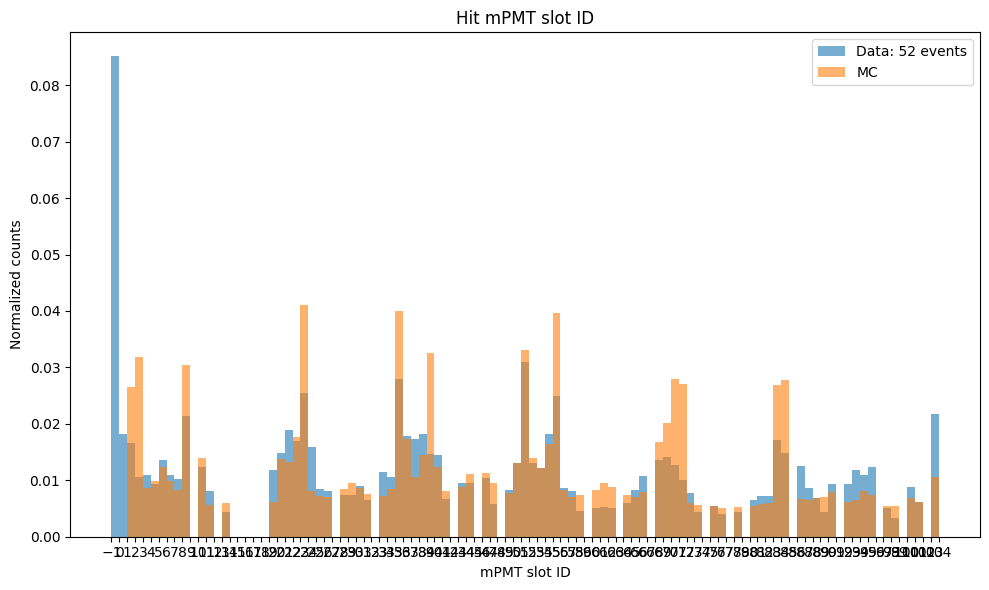

In [20]:
#mPMT slot ids

data_slots = ak.flatten(data["hit_mpmt_slot_ids"])
mc_slots = ak.flatten(mc["hit_mpmt_slot_ids"])

min_slot = int(min(ak.min(data_slots), ak.min(mc_slots)))
max_slot = int(max(ak.max(data_slots), ak.max(mc_slots)))

bins = np.arange(min_slot, max_slot, 1) 

plt.figure(figsize=(10, 6))
plt.hist(data_slots, bins=bins, alpha=0.6, label=f'Data: {len(data)} events', histtype='stepfilled', density=True)
plt.hist(mc_slots, bins=bins, alpha=0.6, label='MC', histtype='stepfilled', density=True)

plt.xlabel('mPMT slot ID')
plt.ylabel('Normalized counts')
plt.title('Hit mPMT slot ID')
plt.legend()
plt.tight_layout()
plt.xticks(np.arange(min_slot, max_slot))  

plt.show()

- We want slot_ids vs. charge (not only vs counts)

- Let's identify and separate PMT ids

In [21]:
#convert 1D flatten arrays into Numpy arrays
data_slots = ak.to_numpy(ak.flatten(data["hit_mpmt_slot_ids"]))
data_charges = ak.to_numpy(ak.flatten(data["hit_pmt_charges"]))     #data_charges = ak.flatten(data["hit_pmt_charges"])
data_channels = ak.to_numpy(ak.flatten(data["hit_pmt_channel_ids"]))
data_positions = ak.to_numpy(ak.flatten(data["hit_pmt_position_ids"]))

mc_slots = ak.to_numpy(ak.flatten(mc["hit_mpmt_slot_ids"]))
mc_charges = ak.to_numpy(ak.flatten(mc["hit_pmt_charges"]))
mc_channels = ak.to_numpy(ak.flatten(mc["hit_pmt_channel_ids"]))
mc_positions = ak.to_numpy(ak.flatten(mc["hit_pmt_position_ids"]))


#aligning slot_id and charge pairs correctly with zip
valid_data = [
    (slot, charge, channel, position)
    for slot_list, charge_list, channel_list, pos_list in zip(
        data["hit_mpmt_slot_ids"],
        data["hit_pmt_charges"],
        data["hit_pmt_channel_ids"],
        data["hit_pmt_position_ids"]
    )
    for slot, charge, channel, position in zip(slot_list, charge_list, channel_list, pos_list)
    if slot != -1  
]

valid_mc = [
    (slot, charge, channel, position)
    for slot_list, charge_list, channel_list, pos_list in zip(
        mc["hit_mpmt_slot_ids"],
        mc["hit_pmt_charges"],
        mc["hit_pmt_channel_ids"],
        mc["hit_pmt_position_ids"]
    )
    for slot, charge, channel, position in zip(slot_list, charge_list, channel_list, pos_list)
]


#unpack en arrays alineados
data_slots, data_charges, data_channels, data_positions = zip(*valid_data)
data_slots = np.array(data_slots)
data_charges = np.array(data_charges)
data_channels = np.array(data_channels)
data_positions = np.array(data_positions)
data_pmt_ids = 19 * data_slots + data_positions     #and compute pmt_ids - we identify each PMT ID across all slots

mc_slots, mc_charges, mc_channels, mc_positions = zip(*valid_mc)
mc_slots = np.array(mc_slots)
mc_charges = np.array(mc_charges)
mc_channels = np.array(mc_channels)
mc_positions = np.array(mc_positions)
mc_pmt_ids = 19 * mc_slots + mc_positions

print("data_slot", data_slots)
print(max(data_slots))
print("mc_slot", mc_slots)
print(max(mc_slots))

print(len(data_slots))
print(len(mc_slots))

data_slot [62 60 29 ... 51 51 51]
105
mc_slot [105  30   8 ...  31  40  26]
105
17924
555445


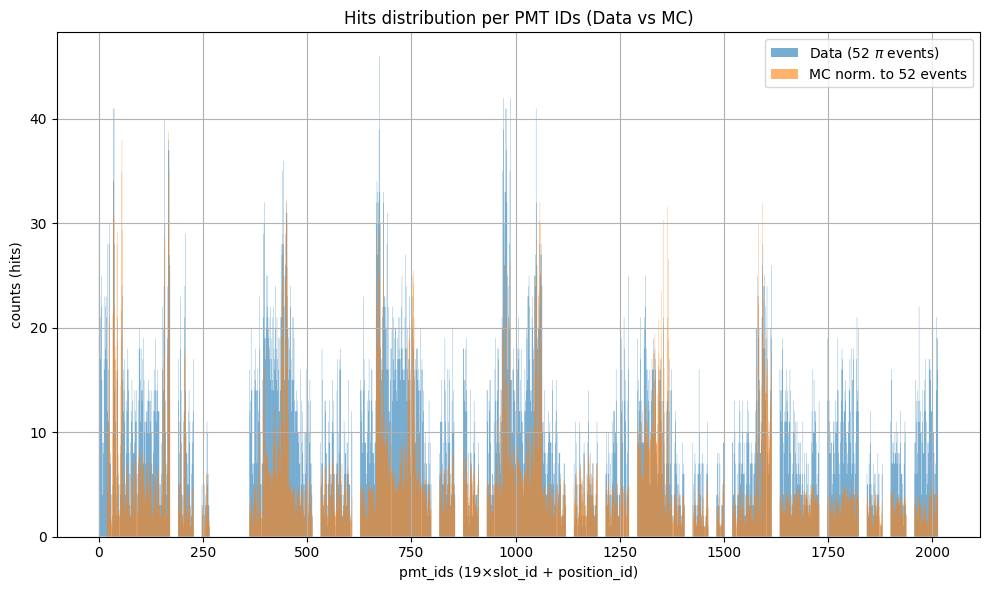

In [22]:
plt.figure(figsize=(10, 6))

max_id = max(data_pmt_ids.max(), mc_pmt_ids.max())
bins = range(0, max_id + 2)
weights = np.ones_like(mc_pmt_ids)*len(data) / len(mc)   #we normalize MC to Data since Data is "true" and we are checking how well MC reproduces Data

plt.hist(data_pmt_ids, bins=bins, alpha=0.6, label=f"Data ({len(data)} $\pi$ events)", histtype='stepfilled')
plt.hist(mc_pmt_ids, bins=bins, alpha=0.6, label=f"MC norm. to {len(data)} events", weights=weights, histtype='stepfilled')

plt.xlabel("pmt_ids (19×slot_id + position_id)")
plt.ylabel(f"counts (hits)")
plt.title("Hits distribution per PMT IDs (Data vs MC)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


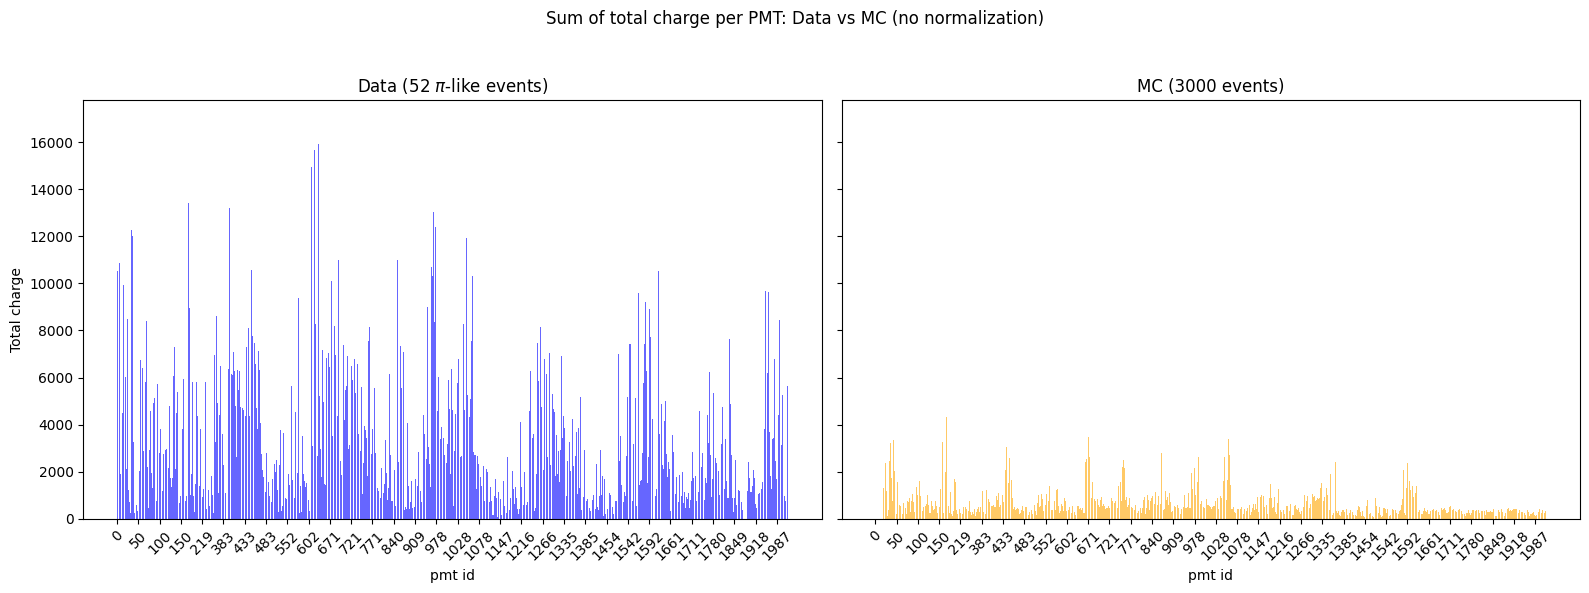

In [23]:
from collections import defaultdict  #works like a normal dictionary but allows you to specify a default value for keys don't exist yet


def sum_charges_per_pmt(pmt_ids, charges):
    total_charge = defaultdict(float)  #creates a dictionary "total_charge" where 0.0 (float) is the default value
    for pid, q in zip(pmt_ids, charges):
        total_charge[pid] += q
    return total_charge   #returns the dictionary where keys are pmt_ids and values are the charges (thus, total charges per pmt ids)

data_charge_per_pmt = sum_charges_per_pmt(data_pmt_ids, data_charges)  
mc_charge_per_pmt = sum_charges_per_pmt(mc_pmt_ids, mc_charges)

all_pmt_ids = sorted(set(data_charge_per_pmt.keys()).union(mc_charge_per_pmt.keys()))   #list of all unique pmt_ids for Data and MC

data_vals = [data_charge_per_pmt.get(pid, 0) for pid in all_pmt_ids]       #summed charge for each pmt
mc_vals = [mc_charge_per_pmt.get(pid, 0) for pid in all_pmt_ids]

indices = np.arange(len(all_pmt_ids))
bar_width = 0.8

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

ax1.bar(indices, data_vals, width=bar_width, color = "blue", alpha=0.6)
ax1.set_title(f"Data ({len(data)} $\pi$-like events)")
ax1.set_xlabel("pmt id")
ax1.set_ylabel("Total charge")
ax1.set_xticks(indices[::50])  # Show fewer xticks
ax1.set_xticklabels([str(pid) for pid in all_pmt_ids[::50]], rotation=45)

ax2.bar(indices, mc_vals, width=bar_width, color = "orange", alpha=0.6)
ax2.set_title(f"MC ({len(mc)} events)")
ax2.set_xlabel("pmt id")
ax2.set_xticks(indices[::50])
ax2.set_xticklabels([str(pid) for pid in all_pmt_ids[::50]], rotation=45)

plt.suptitle("Sum of total charge per PMT: Data vs MC (no normalization)")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

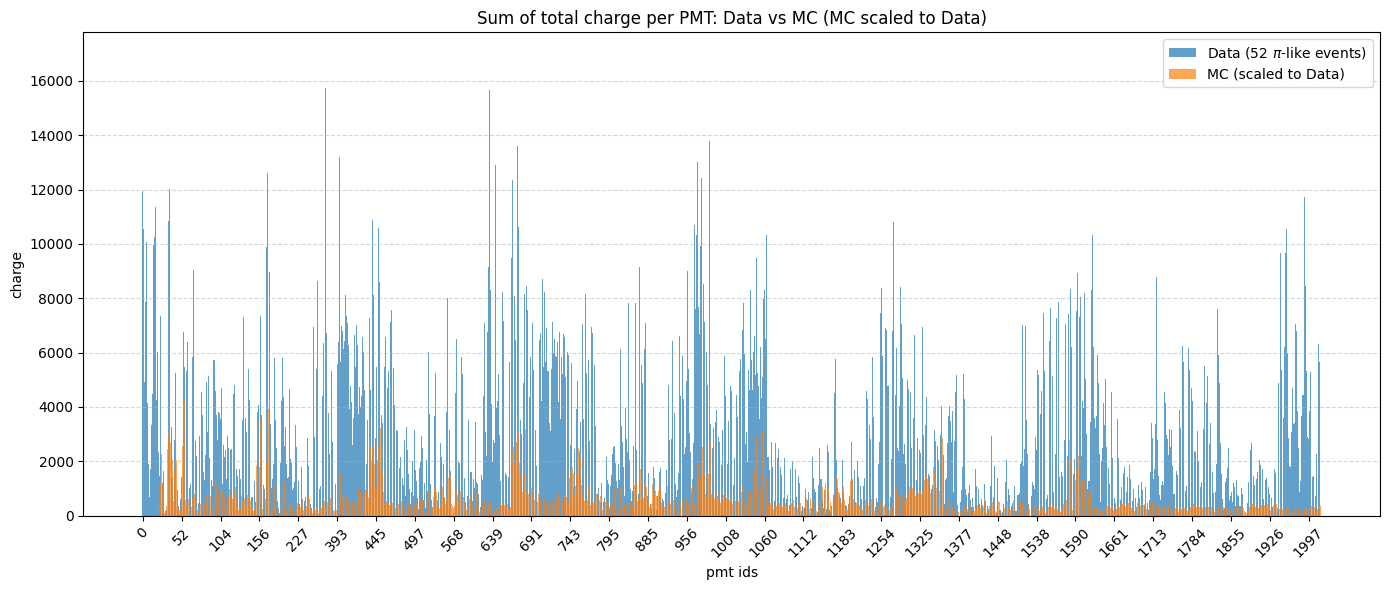

In [24]:
norm_factor = len(data) / len(mc)
for pid in mc_charge_per_pmt:
    mc_charge_per_pmt[pid] *= norm_factor

plt.figure(figsize=(14, 6))
plt.bar(indices - bar_width/2, data_vals, width=bar_width, label=f"Data ({len(data)} $\pi$-like events)", alpha=0.7)
plt.bar(indices + bar_width/2, mc_vals, width=bar_width, label=f"MC (scaled to Data)", alpha=0.7)

step = max(1, len(all_pmt_ids) // 30)  # show about 30 ticks max
xtick_locs = indices[::step]
xtick_labels = [str(all_pmt_ids[i]) for i in range(0, len(all_pmt_ids), step)]

plt.xticks(xtick_locs, xtick_labels, rotation=45)
plt.xlabel("pmt ids")
plt.ylabel("charge")
plt.title("Sum of total charge per PMT: Data vs MC (MC scaled to Data)")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
per_pmt_scale_factors = {}

for pid in data_charge_per_pmt:
    q_data = data_charge_per_pmt[pid]
    q_mc = mc_charge_per_pmt.get(pid, 0)

    if q_data > 0 and q_mc > 0:
        scale = q_mc / q_data
        per_pmt_scale_factors[pid] = scale
    else:
        continue         #if no Data or MC charge, skip to avoid division by zero or irrelevant PMTs


print("PMT specific ADC --> P.E. scale factors (only PMTs with data and MC):")
for pid in sorted(per_pmt_scale_factors):
    scale = per_pmt_scale_factors[pid]
    slot_id = pid // 19
    position_id = pid % 19
    print(f"  PMT ID: {pid:3} (slot {slot_id:2}, pos {position_id:2}) → scale factor: {scale:.3f}")

PMT specific ADC --> P.E. scale factors (only PMTs with data and MC):
  PMT ID:  19 (slot  1, pos  0) → scale factor: 0.005
  PMT ID:  20 (slot  1, pos  1) → scale factor: 0.004
  PMT ID:  21 (slot  1, pos  2) → scale factor: 0.003
  PMT ID:  22 (slot  1, pos  3) → scale factor: 0.004
  PMT ID:  23 (slot  1, pos  4) → scale factor: 0.014
  PMT ID:  24 (slot  1, pos  5) → scale factor: 0.006
  PMT ID:  25 (slot  1, pos  6) → scale factor: 0.005
  PMT ID:  26 (slot  1, pos  7) → scale factor: 0.013
  PMT ID:  27 (slot  1, pos  8) → scale factor: 0.004
  PMT ID:  28 (slot  1, pos  9) → scale factor: 0.002
  PMT ID:  29 (slot  1, pos 10) → scale factor: 0.002
  PMT ID:  31 (slot  1, pos 12) → scale factor: 0.037
  PMT ID:  32 (slot  1, pos 13) → scale factor: 0.085
  PMT ID:  33 (slot  1, pos 14) → scale factor: 0.027
  PMT ID:  34 (slot  1, pos 15) → scale factor: 0.004
  PMT ID:  35 (slot  1, pos 16) → scale factor: 0.005
  PMT ID:  36 (slot  1, pos 17) → scale factor: 0.005
  PMT ID:  3

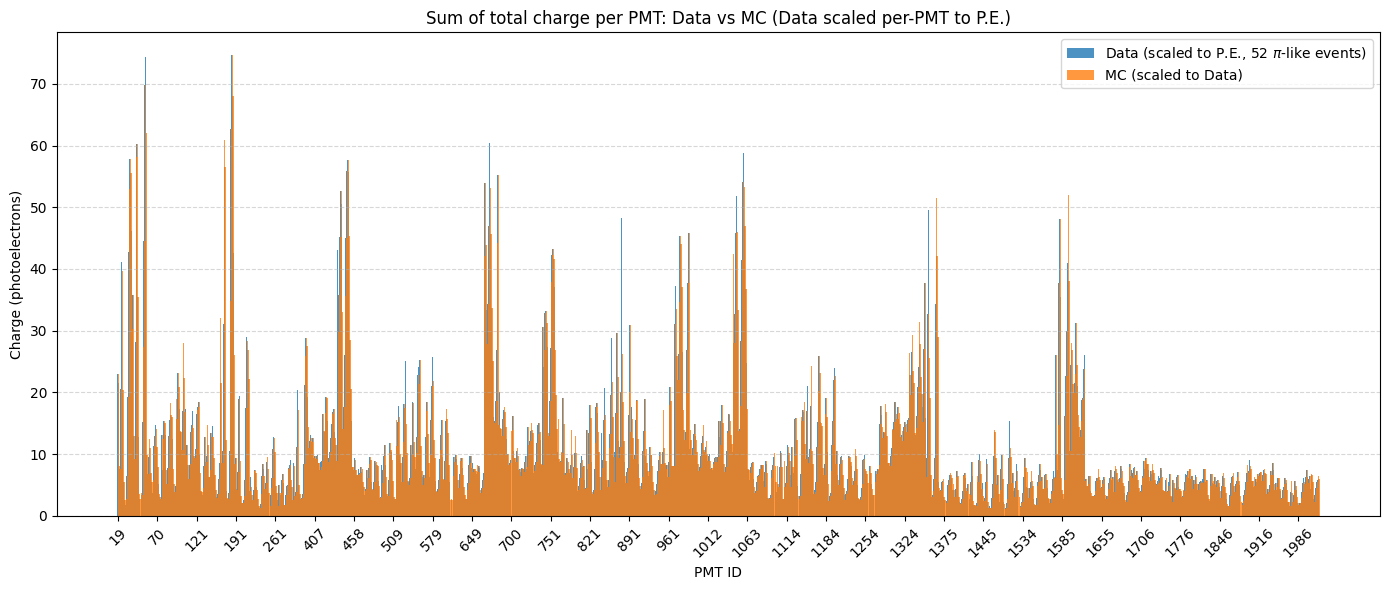

In [26]:
# Step 1: Compute scaled data charges using per-PMT scale factor
scaled_data_charge_per_pmt = defaultdict(float)

for pid, charge in data_charge_per_pmt.items():
    scale = per_pmt_scale_factors.get(pid, None)
    if scale is not None:
        scaled_data_charge_per_pmt[pid] = charge * scale  # convert ADC to P.E.
    else:
        # PMT not in MC → skip (no scale factor)
        continue

# Step 2: No need to re-normalize MC again — it’s already scaled once
# mc_charge_per_pmt is already normalized by norm_factor earlier

# Step 3: Prepare values for aligned PMT IDs
all_pmt_ids = sorted(set(scaled_data_charge_per_pmt.keys()).union(mc_charge_per_pmt.keys()))
data_vals = [scaled_data_charge_per_pmt.get(pid, 0) for pid in all_pmt_ids]
mc_vals = [mc_charge_per_pmt.get(pid, 0) for pid in all_pmt_ids]


plt.figure(figsize=(14, 6))
bar_width = 1
indices = np.arange(len(all_pmt_ids))

plt.bar(indices - bar_width/2, data_vals, width=bar_width,
        label=f"Data (scaled to P.E., {len(data)} $\pi$-like events)", alpha=0.8)
plt.bar(indices + bar_width/2, mc_vals, width=bar_width,
        linewidth = 0.3, label=f"MC (scaled to Data)", alpha=0.8)

# Show only ~30 xticks
step = max(1, len(all_pmt_ids) // 30)
xtick_locs = indices[::step]
xtick_labels = [str(all_pmt_ids[i]) for i in range(0, len(all_pmt_ids), step)]

plt.xticks(xtick_locs, xtick_labels, rotation=45)
plt.xlabel("PMT ID")
plt.ylabel("Charge (photoelectrons)")
plt.title("Sum of total charge per PMT: Data vs MC (Data scaled per-PMT to P.E.)")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

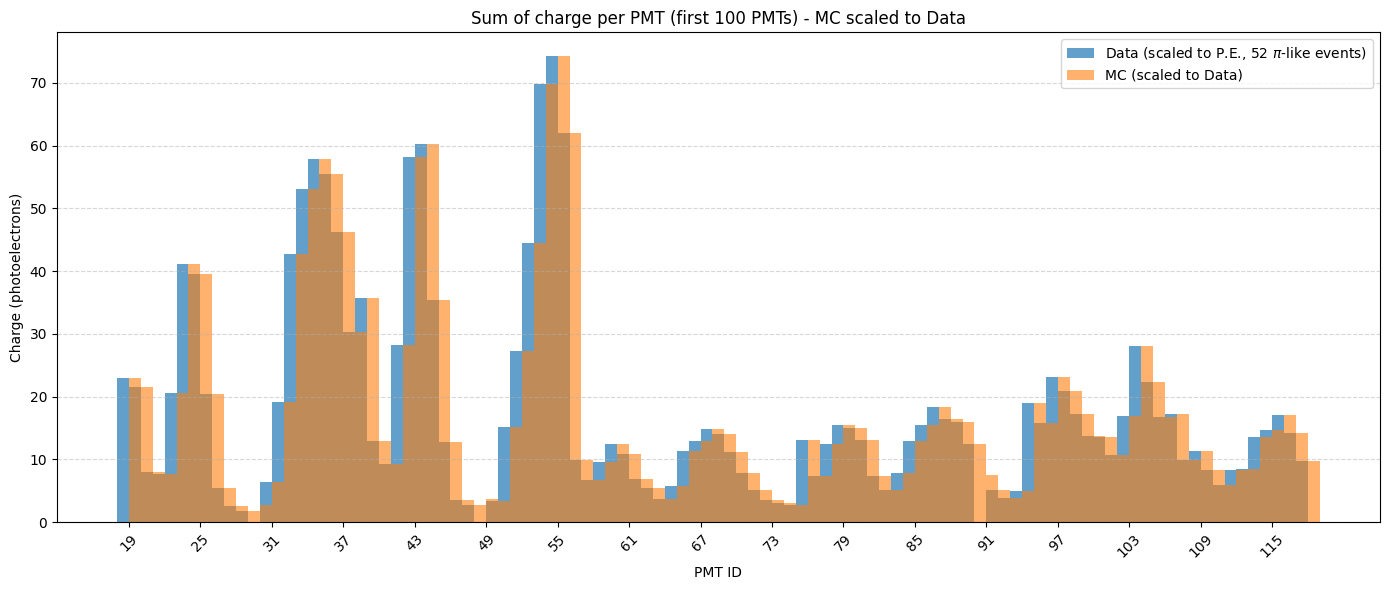

In [27]:
range_limit = 100  # cantidad de PMTs a mostrar

plt.figure(figsize=(14, 6))
bar_width = 1

indices = np.arange(range_limit)

# Corta las listas de valores para que tengan longitud 'range_limit'
data_vals_limited = data_vals[:range_limit]
mc_vals_limited = mc_vals[:range_limit]

plt.bar(indices - bar_width/2, data_vals_limited, width=bar_width,
        label=f"Data (scaled to P.E., {len(data)} $\pi$-like events)", alpha=0.7)

plt.bar(indices + bar_width/2, mc_vals_limited, width=bar_width,
        label=f"MC (scaled to Data)", alpha=0.6)

step = max(1, range_limit // 15)  # Mostrar ~15 ticks como máximo
xtick_locs = indices[::step]
xtick_labels = [str(all_pmt_ids[i]) for i in range(0, range_limit, step)]

plt.xticks(xtick_locs, xtick_labels, rotation=45)
plt.xlabel("PMT ID")
plt.ylabel("Charge (photoelectrons)")
plt.title(f"Sum of charge per PMT (first {range_limit} PMTs) - MC scaled to Data")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
sorted_data_ids = sorted(data_pmt_ids)
sorted_mc_ids = sorted(mc_pmt_ids)

print("First 10 sorted Data PMT IDs:", sorted_data_ids[:10])
print("First 10 sorted MC PMT IDs:", sorted_mc_ids[:10])


data_pmt_ids = 19 * data_slots + data_positions
print(data_pmt_ids)


First 10 sorted Data PMT IDs: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
First 10 sorted MC PMT IDs: [19, 19, 19, 19, 19, 19, 19, 19, 19, 19]
[1195 1156  551 ...  981  974  987]


Scale factor: $SF_\text{slot} = \frac{\langle Q \rangle_\text{Data}(\text{slot})}{\langle Q \rangle_\text{MC}(\text{slot})}$

In [29]:
df_data = pd.DataFrame({'slot': data_slots, 'charge': data_charges})
df_mc = pd.DataFrame({'slot': mc_slots, 'charge': mc_charges})


mean_data = df_data.groupby("slot")["charge"].mean()   #we group those hits that belong to the same slot
mean_mc = df_mc.groupby("slot")["charge"].mean()         #and then we calculate the charge mean (<Q>) of those hits per slot


#resultado: pandas.Series (una sola columna con índice)
#hemos agrupado el df (df_data) por la columna "slot"


# Crear DataFrame conjunto where each row is an slot_id
scale_factors = pd.DataFrame({"mean_charge_data": mean_data, "mean_charge_mc": mean_mc})
scale_factors["scale_factor"] = scale_factors["mean_charge_data"] / scale_factors["mean_charge_mc"]   #adding the "scale_factor" column
print(scale_factors)


average_scale_factor = scale_factors["scale_factor"].mean()
print(f"The average scale factor is", average_scale_factor)

      mean_charge_data  mean_charge_mc  scale_factor
slot                                                
0           365.806818             NaN           NaN
1           252.081250        1.871882    134.667294
2           204.466019        1.937596    105.525598
3           344.323810        1.932501    178.175246
4           261.879121        2.225001    117.698413
...                ...             ...           ...
100         182.672515        1.916794     95.301090
101         159.714286        1.963779     81.330079
103         449.679612        1.542621    291.503569
104         414.427230        1.507790    274.857346
105         285.004115        1.448979    196.693004

[83 rows x 3 columns]
The average scale factor is 154.54922188713462


In [30]:
print("slots in data:", len((data_slots)))
print("slots in MC:", len((mc_slots)))
print("slots in scale_factors:", len(scale_factors))

print("-------------------------------------------")

print("length mc_data", len((mc_charges)))

slots in data: 17924
slots in MC: 555445
slots in scale_factors: 83
-------------------------------------------
length mc_data 555445


# averaged scale factor applied

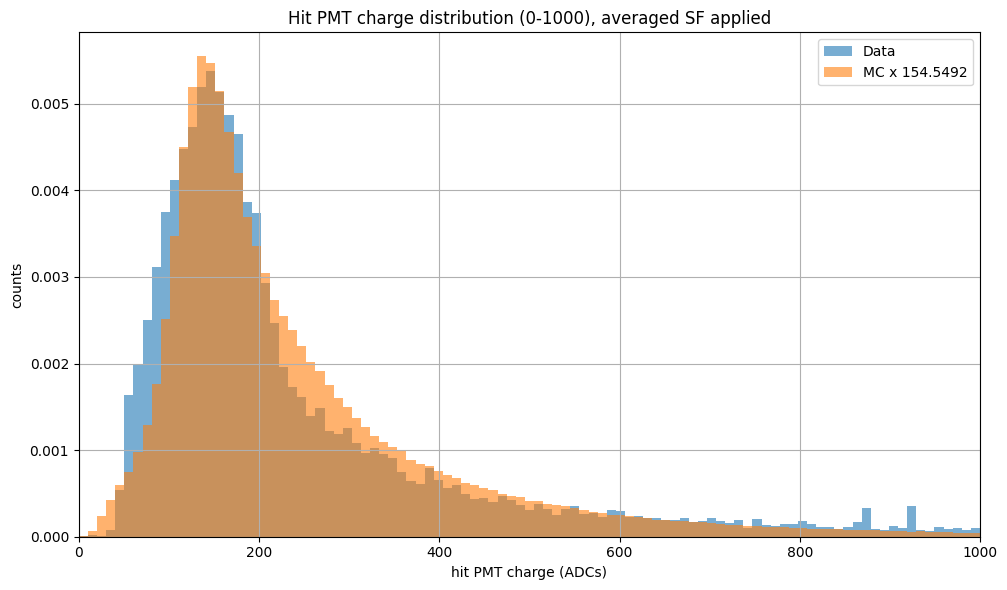

In [31]:
data_charges = ak.flatten(data["hit_pmt_charges"])
mc_charges = ak.flatten(mc["hit_pmt_charges"]) * average_scale_factor  #scale factor

min_range_charge = 0
max_range_charge = 1000

data_charges = data_charges[(data_charges >= min_range_charge) & (data_charges <= max_range_charge)]
mc_charges = mc_charges[(mc_charges >= min_range_charge) & (mc_charges <= max_range_charge)]

bins = np.linspace(min_range_charge, max_range_charge, 100)

plt.figure(figsize=(10, 6))
plt.hist(data_charges, bins=bins, alpha=0.6, label=f'Data', histtype='stepfilled', density=True)
plt.hist(mc_charges, bins=bins, alpha=0.6, label=f'MC x {average_scale_factor:.4f}', histtype='stepfilled', density=True)

plt.xlabel('hit PMT charge (ADCs)')
plt.ylabel('counts')
plt.title('Hit PMT charge distribution (0-1000), averaged SF applied')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(min_range_charge, max_range_charge)

plt.show()

# now calculate the scale factor per slot id and plot it

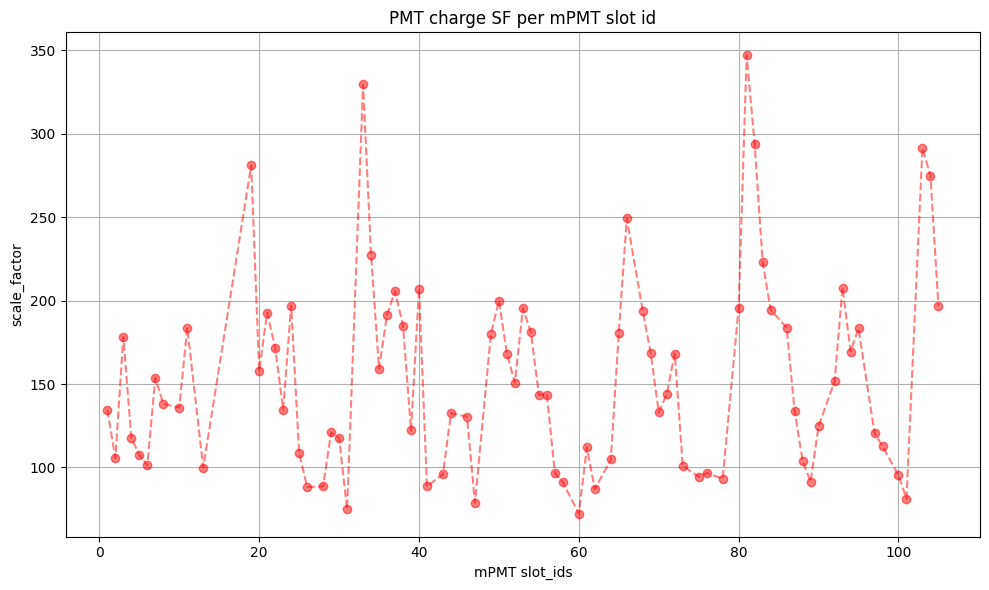

In [32]:
plt.figure(figsize=(10,6))
slot = scale_factors.index      #recal scale_factors is a df where the index corresponds to the "slot_ids".
plt.plot(slot, scale_factors["scale_factor"], marker="o", linestyle='--', color='r', alpha=0.5)
plt.xlabel("mPMT slot_ids")
plt.ylabel("scale_factor")
plt.title("PMT charge SF per mPMT slot id")
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
print("mc_charges:", len(mc_charges))
print("mc_slots:", len(mc_slots))

mc_charges: 634577
mc_slots: 555445


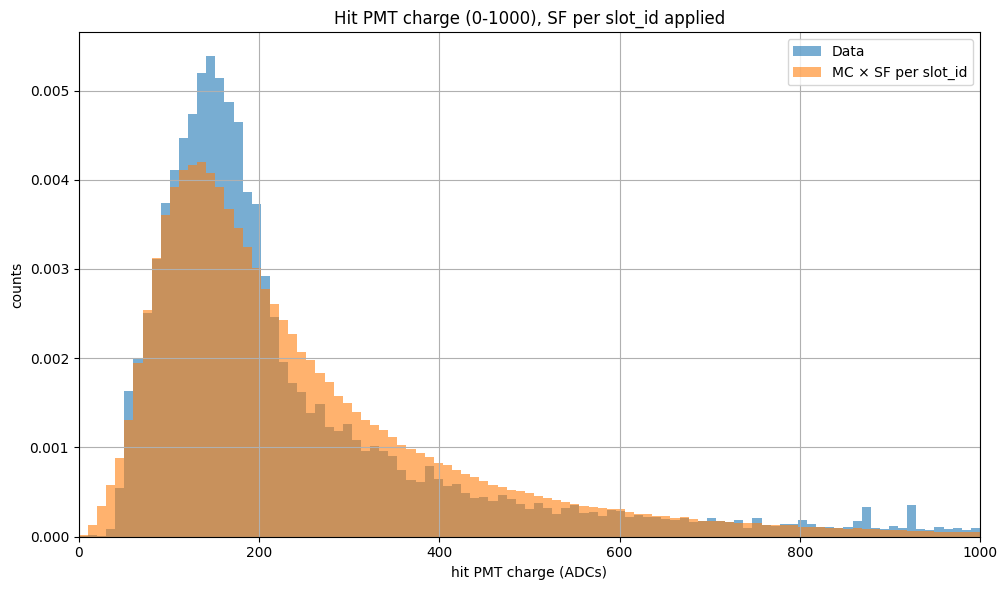

In [34]:
data_slots = ak.to_numpy(ak.flatten(data["hit_mpmt_slot_ids"]))
data_charges = ak.to_numpy(ak.flatten(data["hit_pmt_charges"]))     #data_charges = ak.flatten(data["hit_pmt_charges"])

mc_slots = ak.to_numpy(ak.flatten(mc["hit_mpmt_slot_ids"]))
mc_charges = ak.to_numpy(ak.flatten(mc["hit_pmt_charges"]))

#se pueden desalinear los datos, so we use this line to avoid it 
valid_mc = [(slot, charge) for slot_list, charge_list in zip(mc["hit_mpmt_slot_ids"], mc["hit_pmt_charges"]) for slot, charge in zip(slot_list, charge_list)]
valid_data = [(slot, charge) for slot_list, charge_list in zip(data["hit_mpmt_slot_ids"], data["hit_pmt_charges"]) for slot, charge in zip(slot_list, charge_list)]


# Separar en arrays alineados
mc_slots, mc_charges = zip(*valid_mc)
mc_slots = np.array(mc_slots)
mc_charges = np.array(mc_charges)

data_slots, data_charges = zip(*valid_data)
data_slots = np.array(data_slots)     
data_charges = np.array(data_charges)


slot_to_sf = scale_factors["scale_factor"].to_dict()  #we convert the "scale_factor" column of the "scale_factors" df, into a dictionary, cuyos índices son los slot_ids

# Aplicar factor de escala a cada MC hit según slot_id
sf_per_hit = np.array([slot_to_sf.get(slot, 1.0) for slot in mc_slots])  # default: 1.0 si el slot no está
                                                                                #aplica el SF correspondiente para cada hit (correspondiente según su slot_id)


mc_charges_scaled = mc_charges * sf_per_hit


min_range_charge = 0
max_range_charge = 1000

data_charges = data_charges[(data_charges >= min_range_charge) & (data_charges <= max_range_charge)]
mc_charges_scaled = mc_charges_scaled[(mc_charges_scaled >= min_range_charge) & (mc_charges_scaled <= max_range_charge)]


bins = np.linspace(min_range_charge, max_range_charge, 100)


plt.figure(figsize=(10, 6))
plt.hist(data_charges, bins=bins, alpha=0.6, label=f'Data', histtype='stepfilled', density=True)
plt.hist(mc_charges_scaled, bins=bins, alpha=0.6, label='MC × SF per slot_id', histtype='stepfilled', density=True)

plt.xlabel('hit PMT charge (ADCs)')
plt.ylabel('counts')
plt.title('Hit PMT charge (0-1000), SF per slot_id applied')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(min_range_charge, max_range_charge)
plt.show()

# Now let's do the same for PMTs instead of mPMTs (using slot and channel)

In [35]:
# Flattened + aligned data
# This guarantees that each slot, channel, and charge come from the same hit, within the same event.


valid_data = [
    (slot, chan, charge)
    for slot_list, chan_list, charge_list in zip(data["hit_mpmt_slot_ids"], data["hit_pmt_channel_ids"], data["hit_pmt_charges"])
    for slot, chan, charge in zip(slot_list, chan_list, charge_list)
]

valid_mc = [
    (slot, chan, charge)
    for slot_list, chan_list, charge_list in zip(mc["hit_mpmt_slot_ids"], mc["hit_pmt_channel_ids"], mc["hit_pmt_charges"])
    for slot, chan, charge in zip(slot_list, chan_list, charge_list)
]

# Convert to DataFrames
df_data = pd.DataFrame(valid_data, columns=["slot", "channel", "charge"])
df_mc = pd.DataFrame(valid_mc, columns=["slot", "channel", "charge"])


In [36]:
mean_data = df_data.groupby(["slot", "channel"])["charge"].mean()
mean_mc = df_mc.groupby(["slot", "channel"])["charge"].mean()

In [37]:
scale_factors = pd.DataFrame({
    "mean_charge_data": mean_data,
    "mean_charge_mc": mean_mc,
})
scale_factors["scale_factor"] = scale_factors["mean_charge_data"] / scale_factors["mean_charge_mc"]

In [38]:
# Turn into a dictionary for fast lookup
slot_channel_to_sf = scale_factors["scale_factor"].to_dict()

# Reconstruct MC hit info
mc_slots, mc_channels, mc_charges = zip(*valid_mc)
mc_slots = np.array(mc_slots)
mc_channels = np.array(mc_channels)
mc_charges = np.array(mc_charges)

# Lookup SF for each (slot, channel) pair
sf_per_hit = np.array([
    slot_channel_to_sf.get((slot, chan), 1.0)  # default: 1.0 if no match
    for slot, chan in zip(mc_slots, mc_channels)
])

# Apply scale
mc_charges_scaled = mc_charges * sf_per_hit

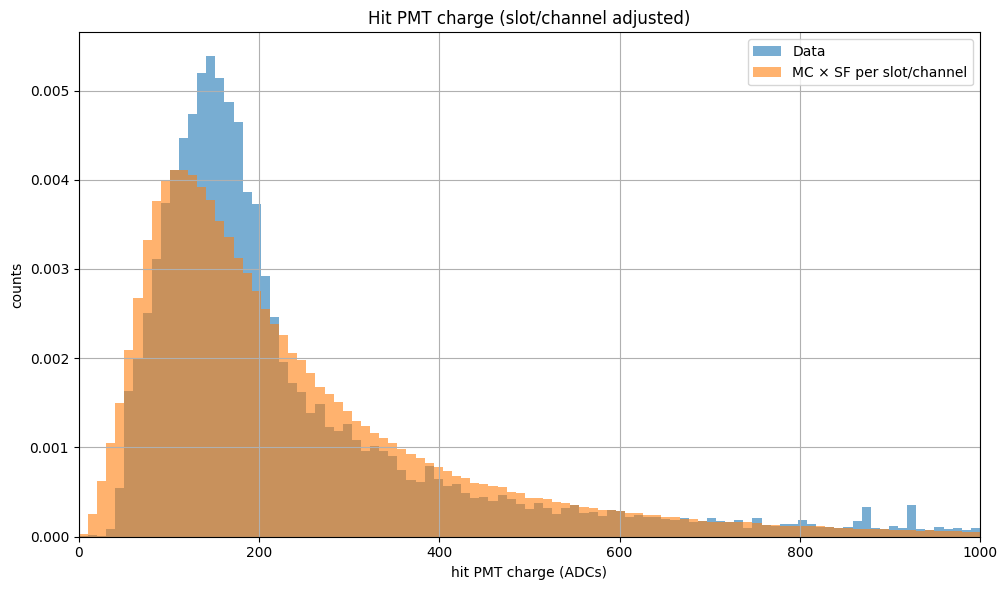

In [39]:
# Cut ranges
min_range_charge = 0
max_range_charge = 1000
bins = np.linspace(min_range_charge, max_range_charge, 100)

data_charges = df_data["charge"]
mc_charges_scaled = mc_charges_scaled

data_charges = data_charges[(data_charges >= min_range_charge) & (data_charges <= max_range_charge)]
mc_charges_scaled = mc_charges_scaled[(mc_charges_scaled >= min_range_charge) & (mc_charges_scaled <= max_range_charge)]

plt.figure(figsize=(10, 6))
plt.hist(data_charges, bins=bins, alpha=0.6, label='Data', histtype='stepfilled', density=True)
plt.hist(mc_charges_scaled, bins=bins, alpha=0.6, label='MC × SF per slot/channel', histtype='stepfilled', density=True)

plt.xlabel('hit PMT charge (ADCs)')
plt.ylabel('counts')
plt.title('Hit PMT charge (slot/channel adjusted)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(min_range_charge, max_range_charge)
plt.show()

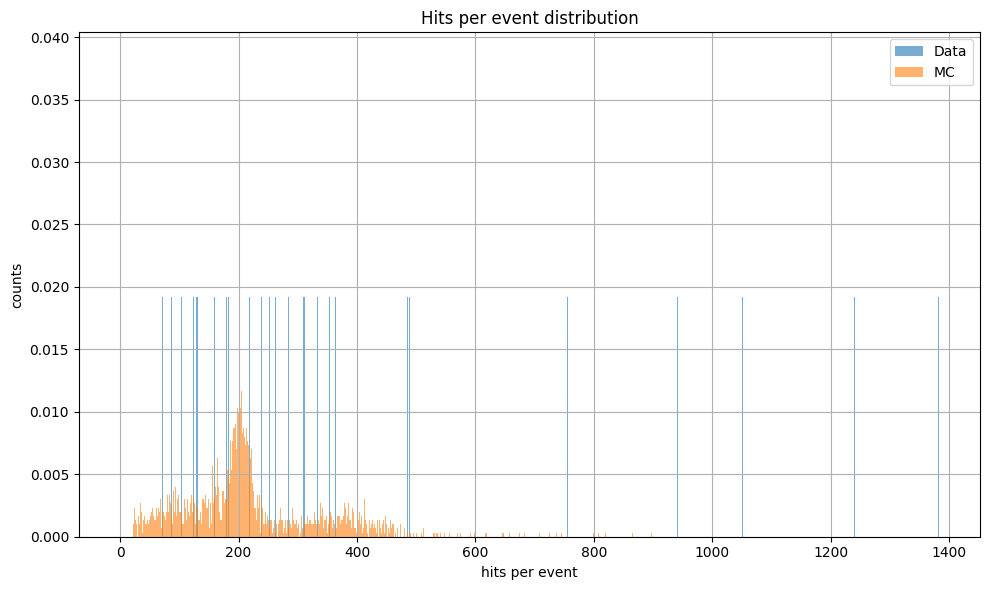

In [40]:
hits_per_event_data = ak.num(data["hit_pmt_charges"])
hits_per_event_mc = ak.num(mc["hit_pmt_charges"])

hits_per_event_data = ak.to_numpy(hits_per_event_data)
hits_per_event_mc = ak.to_numpy(hits_per_event_mc)



# Histograma de # hits per event
bins = np.arange(0, max(hits_per_event_data.max(), hits_per_event_mc.max()) + 2) - 0.5

plt.figure(figsize=(10,6))
plt.hist(hits_per_event_data, bins=bins, alpha=0.6, label="Data", density=True)
plt.hist(hits_per_event_mc, bins=bins, alpha=0.6, label="MC", density=True)

plt.xlabel("hits per event")
plt.ylabel("counts")
plt.title("Hits per event distribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()